# FYS2130 - Computational Essay
In this computational essay we will explore the three body problem and attempt to use it to simulate the orbits of the Earth and Moon around the sun. We will then look at the oscillations of the orbit of the moon and compare our results with available data on the internet. Our goal will be to have a general code for sovling the three body problem that can easily be extended to three dimensions, and which uses the Runge-Kutta integration scheme, this code will then be tested to see if it produces accurate results of the oscillations in the orbit of the moon.

Before we can start we need to have the equations of motion for our three bodies so we can define the differential equation to integrate. The three body problem is solved (numerically) by calculating the forces exerted on each of the bodies and then through numerical integration find the change in velocities which gives us the change in position. Hence, for one body the EoM is
\begin{equation*}
m_1 \frac{d\vec{v}_1}{dt} = G\frac{m_2 m_1}{(\vec{r}_2 - \vec{r}_1)^2}\frac{\vec{r}_2 - \vec{r}_1}{|\vec{r}_2 - \vec{r}_1 |} + G\frac{m_3 m_1}{(\vec{r}_3 - \vec{r}_1)^2}\frac{\vec{r}_3 - \vec{r}_1}{|\vec{r}_3 - \vec{r}_1 |}
\end{equation*}
Similarly, this will then need to be solved for $m_2$ and $m_3$.

Our first goal is to implement these EoM into a function and testing it with arbitrary values using a simple Euler-Cromer algorithm. The next step is to move it into the fourth order Runge-Kutta algorithm, and if the Python Gods are willing, implement real values for our system and compute the orbits we want to study.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

"""setting up the initial conditions"""

init = np.zeros((6,2))

r1 = np.array([0.,0.]);     init[0] = r1
r2 = np.array([0.,1.]);     init[1] = r2
r3 = np.array([0.,-1.]);    init[2] = r3
v1 = np.array([0.,0.]);    init[3] = v1
v2 = np.array([0.3,0.]);     init[4] = v2
v3 = np.array([-0.3,0.]);   init[5] = v3

"""masses and G"""
m1 = 1.;m2 = 1.;m3 = 1.;G = 1.

def F(r):

    r31 = r[2,:] - r[0,:]
    R31 = np.linalg.norm(r31,axis=0) # distance between r1 and r3
    r21 = r[1,:] - r[0,:]
    R21 = np.linalg.norm(r21,axis=0)
    r32 = r[2,:] - r[1,:]
    R32 = np.linalg.norm(r32,axis=0)

    dv = np.zeros((6,2))
    dv[:3,:] = r[3:,:]

    dv[3,:] = G*( ( m3 / ( R31**3 )) * r31 \
                +  ( m2 / ( R21**3 )) * r21 )
    dv[4,:] = G*( ( m3 / ( R32**3 )) * r32 \
                +  ( m1 / ( R21**3 )) *-r21 )
    dv[5,:] =  G*( ( m2 / ( R32**3 )) *-r32 \
                +  ( m1 / ( R31**3 )) *-r31 )

    return dv

## Initial conditions and the differential equation

We structure our program so that it takes an array of shape (6,2,N). This enables us to fill in three two-dimensionl position vectors and three velocity vectors as our initial conditions. The differential equation then takes the position vectors and velocity vectors and calculate the acceleration vectors while storing the current velocities. Thus, all we need to do bring this (6,2) array from step $i$ to $i+1$ is the function $F(r)\cdot dt$, where $dt$ is our time step, if we are using the Euler-Cromer algorithm.

The differential function $F(r)$ first calculates the two vectors pointing from $m_1$ to $m_2$ and $m_3$, and then the vector pointing from $m_2$ to $m_3$. It then takes these to find the norm of these vectors (the distance between the bodies). The other three vectors missing is then easily found by applying a negative sign. The rest of the function is then to compute the acceleration vectors for each of the bodies by solving the EoM as shown above. Here we also pull the factors in the denominator together to simplify the program.

Before proceeding to the implementation of fourth order Runge-Kutta (RK4) we will check to see if our function works as intended by using the simple Euler-Cromer algorithm. We use the simple initial conditions defined above and keep all the masses and the gravitational constant as simple as possible.

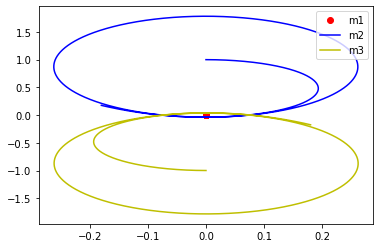

In [5]:
def EC(init,N,T):

    # init should be an array of shape (6,2) [or 6,3 in three dimensions] where
    # the first three rows are the initial positions r1_0, r2_0, r3_0 and the
    # next three are the initial velocities vi_0 ...

    Y = np.zeros((6,2,int(N)))   # master array
    Y[:,:,0] = init         # inserting the init conditions

    dt = T/float(N-1)

    for i in range(int(N)-1):

        Y[:,:,i+1] = Y[:,:,i] + F(Y[:,:,i])*dt

    return Y

def vPlot(Y):

    # A simple matplot of the trajectories, and velocities of the three bodies

    # Getting the position data from the master array Y[#body(r,v),(x,y),N]

    r1x = Y[0,0,:]; r1y = Y[0,1,:]
    r2x = Y[1,0,:]; r2y = Y[1,1,:]
    r3x = Y[2,0,:]; r3y = Y[2,1,:]

    # Plot of trajectories

    plt.plot(r1x, r1y, 'ro', r2x, r2y, 'b', r3x, r3y, 'y')
    plt.legend(['m1', 'm2', 'm3'],loc=1)
    plt.show()

X = EC(init,1e5,6.)
vPlot(X)

As we can see the algorithm seems to function as intended, but the orbits of $m_1$ and $m_3$ have lost a significant amount of energy after the first orbit. This is to be expected when using a first order method such as Euler-Cromer, and this is the reason why we would like to implement RK4 instead! The EC function is simple and takes in the initial values together with the number of time steps and the amount of "time" we wish to run our simulation. In the for-loop it simply uses the function $F(r)$ as described above and multiplies it with $dt$ to find the new positions and velocities. The vPlot function simply extracts the x and y data and plots the positions.

## Implementing RK4

Now we are ready to create our RK4 function. The RK4 method follows a scheme of averaging over four different computed paths of the integral. The method can be outlined as such

\begin{align}
\frac{dy}{dt} &= f(y) \\
k_1 &= f(y) dt \\
k_2 &= f(y + \frac{k_1}{2})dt \\
k_3 &= f(y + \frac{k_2}{2})dt \\
k_4 &= f(y + k_3)dt \\
y_{i+1} &= y_i + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{align}

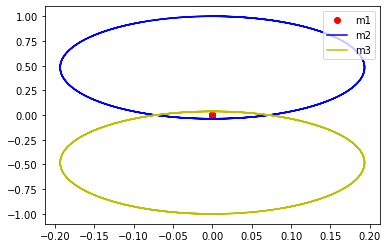

In [6]:
def RK4(init,N,T):

    h = T/float(N-1)
    t = np.linspace(0.,float(T),int(N))
    R = np.zeros((6,2,int(N))) #RK4 master array
    R[:,:,0] = init

    for i in range(int(N)-1):

        K1 = F(R[:,:,i])*h
        K2 = F(R[:,:,i] + K1/2.)*h
        K3 = F(R[:,:,i] + K2/2.)*h
        K4 = F(R[:,:,i] + K3)*h

        R[:,:,i+1] = R[:,:,i] + (1/6.) * (K1 + 2*K2 + 2*K3 + K4)

    return R, t

X2, t = RK4(init,1e5,6.)
vPlot(X2)

The function RK4 takes the initial values, once again stored in a (6,2) array, and the number of time steps $N$ and the duration $T$. It then computes the time step $h$ and sets up an empty array $R$ which we then fill with all the computed data which we get running the RK4 algorithm.

We happily observe that the orbits seems to have improved a lot using this method. And we are now ready to proceed to model the Sun-Earth-Moon orbital system which we set out to do.

## Simulating the orbits of the Earth and the Moon around the Sun

To begin with we will need to decide how to setup our system. The most important part here is to get real values for the initial positions and velocities. For the Sun this is quite simple, we assume that it is completely at rest at the origin of our coordinate system. Realisticly it does oscillate a bit around the center, but this would make our model more complicated than it needs to be. For the Earth we use values found on https://en.wikipedia.org/wiki/Earth%27s_orbit. Where we use the values at the perihelion (where the Earth is at its closest to the Sun). We do the same for the Moon. We start it from its closest (and thus, according to Keplers Law, fastest) point to Earth. We find the values for this at https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html (credit NASA).

Now the next, and hugely important, step is to evaluate what sort of units to have all the data in. The standard SI units are cumbersome when dealing with planetary orbits. Hence, we use the astronomical unit for distance (1 AU is the mean distance between the Sun and the Earth), a year for time, and for mass we use the mass of the Earth as our reference point. Thus, doing some calculations we get the data as shown below:

Sun:
Mass: 332933 M(earth)
Position: (0,0)
Velocity: (0,0)

Earth:
Mass: 1 M(earth)
Position: (-0.98329 AU, 0)
Velocity: (0, -6,385287675 AU/year)

Moon:
Mass: 0.0123 M(earth)
Position: (−0,985718511 AU, 0)
Velocity: (0, −0,228091161 AU/year)

We also need to get the gravitational constant $G$ into our units. Doing this we find $G =$ 0.000118410279617. Since this is a computational essay I take the liberty of not rounding everything off, but we could simply include four digits in all our numbers since this is the least precise data we use.

Before getting into the simulation itself it is worth mentioning some of the assumptions we make here that would be different in the real world. The first, which is most plane-ly in sight, is that we are restricting ourselves to work in two dimensions. For the purpose of this simulation two dimensions should be sufficient, and I doubt that a third would contribute a lot, especially with the limitations on initial value-data. A more major assumption is that we are working with simple point masses for the earth and the moon, since neither are perfect spheres. But this would hugely complicate the simulation. A third and similar assumption is to neglect the tidal forces on the Moon from the oscillations in the Earth's oceans. This would have made for an excellent addition to the model, but it would also make it a lot more complicated.

In addition to all this, our solar system consists of more than three bodies and these would most likely contribute a bit to especially any movement from the origin of the sun. But restricting ourselves to two dimensions and three bodies is within the scope of this simulation.


In [7]:
"""initial values, masses and G [in AU]"""

# Astronomical Units
AU = 149597870.7 #km
year = 365*24*60*60 #s
MassEarth = 5.97237e24 #kg
conv = year/AU
conv2 = MassEarth*year**2/AU**3

G_kiloSI = 6.67430e-20 #km**3/kg*s**2
G = G_kiloSI*conv2# in terms of AU, years and earth mass

init = np.zeros((6,2))

# Values for Sun
m1 = 332933.    # earth masses
r1 = np.array([0.,0.]);     init[0] = r1
v1 = np.array([0.,0.]);    init[3] = v1

# Values for Earth (perihelion)
m2 = 1.
r2 = np.array([-0.98329,0.]);     init[1] = r2
v2 = np.array([0.,-30.29*conv]);     init[4] = v2

#Values for the Moon (perihelion)
m3 = 0.0123
r3 = np.array([r2[0]-0.002428511,0.]);    init[2] = r3
v3 = np.array([0.,v2[1]-1.082*conv]);   init[5] = v3

Y, t = RK4(init,1e6,1.)

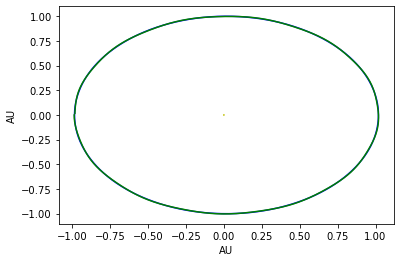

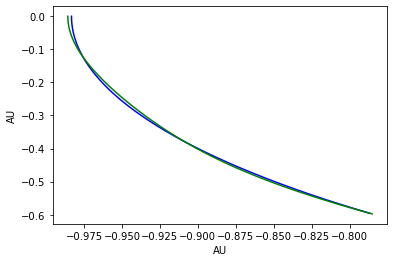

In [16]:
r1x = Y[0,0,:]; r1y = Y[0,1,:]
r2x = Y[1,0,:]; r2y = Y[1,1,:]
r3x = Y[2,0,:]; r3y = Y[2,1,:]

plt.plot(r1x,r1y,'y',r2x,r2y,'b',r3x,r3y,'g')
plt.xlabel('AU')
plt.ylabel('AU')
plt.show()
plt.plot(r2x[:int(1e5)],r2y[:int(1e5)],'b',r3x[:int(1e5)],r3y[:int(1e5)],'g')
plt.xlabel('AU')
plt.ylabel('AU')
plt.show()

The first plot shows the full orbits of both the Earth, the Moon and the Sun in the course of a year. A closer look actually shows that the orbits are not completely filling out the ellipse which is of course caused by a year on earth being approximately 365.25 days, which we have not accounted for.

The second plot takes a closer look at the Earth and the Moons orbits.

We may now compute the distance between the Earth and the Moon to look at how this is oscillating through a year, and we can also do the same for the distance between Earth and the Sun, and check wether we get some oscillations in the position of the sun aswell.

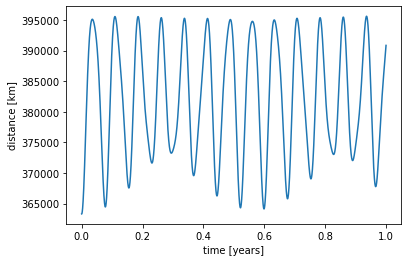

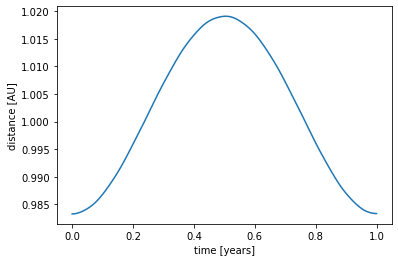

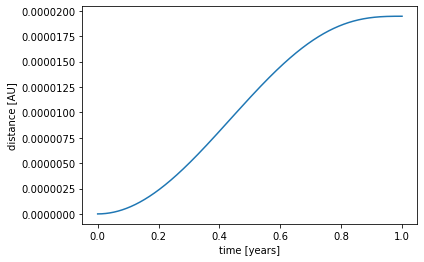

In [15]:
EMvec = (Y[1,:,:] - Y[2,:,:])*AU 
EMdist = np.linalg.norm(EMvec,axis=0) #distance between Earth and Moon in km

ESvec = Y[0,:,:] - Y[1,:,:] #distance between earth and sun in AU
ESdist = np.linalg.norm(ESvec,axis=0)

oscSun = np.linalg.norm(Y[0,:,:],axis=0) #distance of the sun from the origin in AU

plt.plot(t,EMdist)
plt.xlabel('time [years]')
plt.ylabel('distance [km]')
plt.show()

plt.plot(t,ESdist)
plt.xlabel('time [years]')
plt.ylabel('distance [AU]')
plt.show()

plt.plot(t,oscSun)
plt.xlabel('time [years]')
plt.ylabel('distance [AU]')
plt.show()

The first plot shows the oscillations in the orbit of the Moon. Compared to what we can find on wikipedia it seems fairly accurate in representing the oscillations but it is not quite reaching the maximum distance given on wikipedia. A plot of the oscillations can be found on wikipedia: https://en.wikipedia.org/wiki/Orbit_of_the_Moon#/media/File:Moon-Earth_distance,_Moon_phases.gif and is included at the end of the paper.

It seems to fit well with the predictions from our simulation, but there is a small discrepancy at the very end of the graph. It is hard to say exactly what caused this. It could be that the oscillations occur slightly faster than they should due to the systems energy changing. Usually when modelling orbital systems the leap-frog integration method is used which better conserves the energy of the system.

The second plot shows the change in Earth's orbit. This too seems to fit well with the data found on wikipedia (https://en.wikipedia.org/wiki/Earth) where the maximum (aphelion) distance is 1.017 AU.

The third plot shows the change in the Sun's orbit throughout the year. This is most likely highly inaccurate, although I could not find any plots of this on the internet. This could simply be due to the sun generally being the center of our system and thus always the origin, but some models of this effect is probably out there somewhere. This should not be the same as shown here since there are more planets affecting the suns position and since it also is a matter of reference as our entire solar system itself is moving etc.

### Conclusion

In this essay we have worked our way from a simple and general two-dimensional three body system to a simulation computing the orbits of the Earth and the Moon around the Sun. We implemented the simple Euler-Cromer integration algorithm and then moved on to the higher order Runge-Kutta algorithm. Our results seems to stack up well with data found on the internet. The code could still be expanded upon further by implementing leap-frog type integration schemes, but works well for the purposes of this essay. We also briefly looked at possible flaws in the method including the tidal forces of Earth's oceans and the non-spherical shapes of the bodies.

![moon.png](img/moon.png)